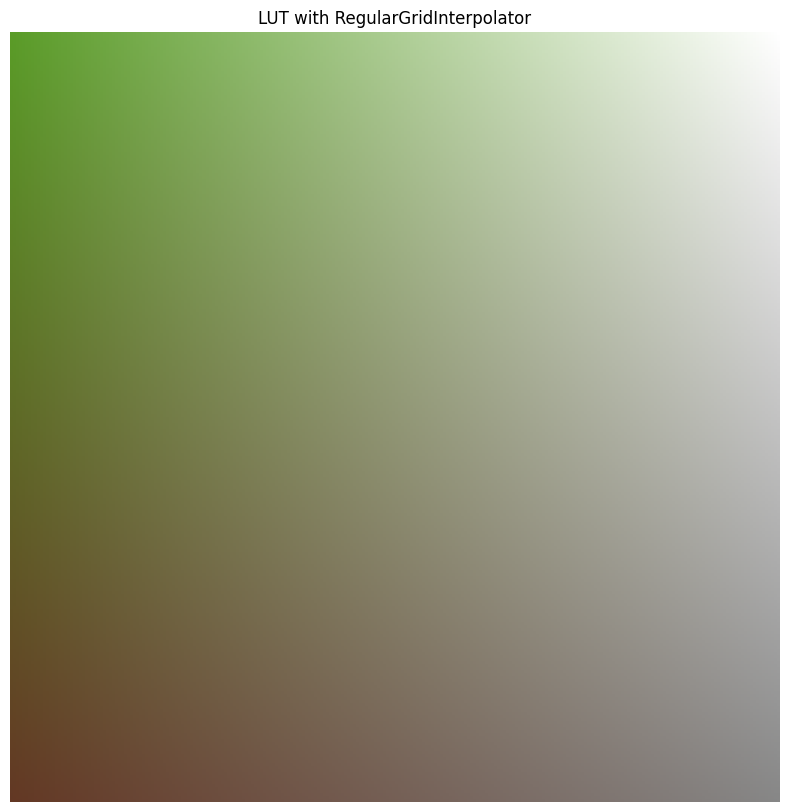

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

# Define base colors for each corner (low steepness/low height, etc.)
low_steep_low_height = np.array([90, 156, 40])    # Green (grass)
low_steep_high_height = np.array([255, 255, 255]) # White (snow)
# low_steep_low_height = np.array([255, 0, 0])    # Green (grass)
# low_steep_high_height = np.array([0, 255, 0]) # White (snow)
high_steep_low_height = np.array([99, 56, 36])    # Brown (dirt/rock)
high_steep_high_height = np.array([135, 135, 135]) # Grey (rock)

# Define LUT size
lut_size = 256
lut = np.zeros((lut_size, lut_size, 3), dtype=np.uint8)

# Create the grid points for interpolation
grid_points = (np.array([0, 1]), np.array([0, 1]))

# Interpolate each RGB channel individually using RegularGridInterpolator
for channel in range(3):
    # Define values at the corners for the current channel
    values = np.array([
        [low_steep_low_height[channel], low_steep_high_height[channel]],
        [high_steep_low_height[channel], high_steep_high_height[channel]]
    ])
    
    # Create an interpolator object
    interp_func = RegularGridInterpolator(grid_points, values, method='linear')
    
    # Fill in the LUT by sampling the interpolator
    for i in range(lut_size):
        for j in range(lut_size):
            # Normalize indices to [0, 1] range and interpolate
            lut[i, j, channel] = interp_func((i / (lut_size - 1), j / (lut_size - 1)))

# Plot the resulting LUT as an image
plt.figure(figsize=(10, 10))
plt.imshow(lut)
plt.title("LUT with RegularGridInterpolator")
plt.axis('off')
plt.show()


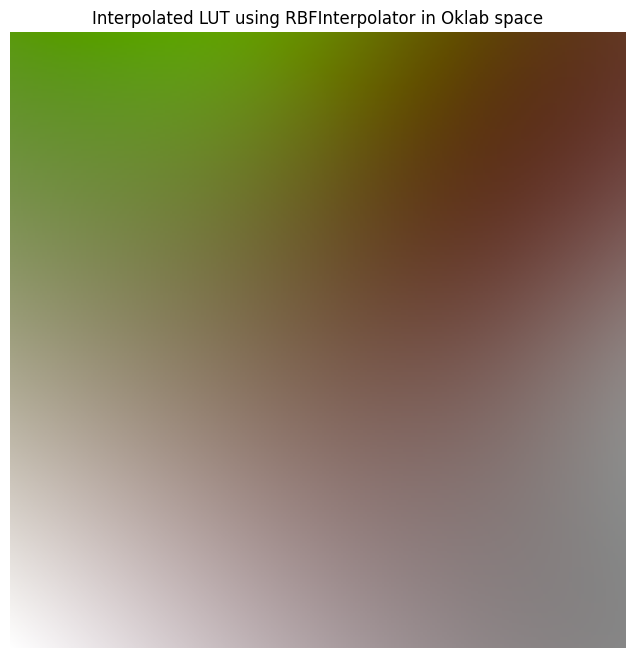

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import Rbf
import colour

def sRGB_to_Oklab(srgb):
    srgb_normalized = np.asarray(srgb) / 255.0
    oklab = colour.convert(srgb_normalized, 'sRGB', 'Oklab')
    return oklab

def Oklab_to_sRGB(oklab):
    srgb = colour.convert(oklab, 'Oklab', 'sRGB')
    srgb = np.clip(srgb, 0, 1) * 255
    return srgb.astype(np.uint8)

lut_size = 256
grid_x, grid_y = np.meshgrid(np.linspace(0, 1, lut_size), np.linspace(0, 1, lut_size))

# Define known points with their positions (normalized between 0 and 1) and colors
known_points = [
    # {'pos': (0, 0), 'color': [90, 156, 64]},        # Grass
    {'pos': (0, 0), 'color': [90, 155, 11]},        # Grass
    {'pos': (0.4, 0.0), 'color': [100, 155, 0]},        # Grass
    {'pos': (0, 0.5), 'color': [160, 160, 128]},      # Transition to barren
    {'pos': (0, 1), 'color': [255, 255, 255]},      # Exposed rock/ice
    {'pos': (1, 0), 'color': [99, 56, 36]},         # Dirt/rock
    {'pos': (0.75, 0.3), 'color': [99, 56, 36]},         # Dirt/rock
    {'pos': (1, 0.5), 'color': [139, 125, 123]},  # Bare rock
    {'pos': (1, 1), 'color': [135, 135, 135]},    # Grey rock
    #{'pos': (0.5, 0.5), 'color': [0, 0, 255]},     # Additional arbitrary point
    # Add more arbitrary points as needed
]

# Extract positions and convert colors to Oklab
points = np.array([point['pos'] for point in known_points])
colors = np.array([sRGB_to_Oklab(point['color']) for point in known_points])

# # Interpolate each Oklab channel separately
# lut_L = griddata(points, colors[:, 0], (grid_x, grid_y), method='linear')
# lut_a = griddata(points, colors[:, 1], (grid_x, grid_y), method='linear')
# lut_b = griddata(points, colors[:, 2], (grid_x, grid_y), method='linear')

# # Handle any NaN values resulting from interpolation
# lut_L = np.nan_to_num(lut_L, nan=np.nanmean(lut_L))
# lut_a = np.nan_to_num(lut_a, nan=0)
# lut_b = np.nan_to_num(lut_b, nan=0)

rbf_L = Rbf(points[:, 0], points[:, 1], colors[:, 0], function='multiquadric')
rbf_a = Rbf(points[:, 0], points[:, 1], colors[:, 1], function='multiquadric')
rbf_b = Rbf(points[:, 0], points[:, 1], colors[:, 2], function='multiquadric')

lut_L = rbf_L(grid_x, grid_y)
lut_a = rbf_a(grid_x, grid_y)
lut_b = rbf_b(grid_x, grid_y)

lut_oklab = np.stack((lut_L, lut_a, lut_b), axis=-1)
lut_oklab_flat = lut_oklab.reshape(-1, 3)
lut_srgb_flat = Oklab_to_sRGB(lut_oklab_flat)
lut_rgb = lut_srgb_flat.reshape(lut_size, lut_size, 3)

plt.figure(figsize=(8, 8))
plt.imshow(lut_rgb)
plt.title("Interpolated LUT using RBFInterpolator in Oklab space")
plt.axis('off')
plt.show()

In [3]:
# Save the lut as a PNG image
plt.imsave("lut.png", lut_rgb)

In [6]:
# Load the eroded_terrain.csv and display it with plotly as a 3D surface. The csv file is a 2D array of values between 0 and 1.

import numpy as np
from scipy.ndimage import gaussian_filter
import plotly.express as px
import plotly.graph_objects as go

# Load the CSV file
terrain_data = np.loadtxt("eroded_terrain.csv", delimiter=",")

# Apply Gaussian filter to smooth the terrain data
terrain_data = gaussian_filter(terrain_data, sigma=2)

# Create a meshgrid for the x and y coordinates
x = np.linspace(0, 1, terrain_data.shape[1])
y = np.linspace(0, 1, terrain_data.shape[0])
X, Y = np.meshgrid(x, y)
# Create a 3D surface plot
fig = go.Figure(data=[go.Surface(z=terrain_data, x=X, y=Y, colorscale='Viridis')])
# Update layout
fig.update_layout(title='Eroded Terrain', scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Height'
))
# Show the plot
fig.show()

# Save the smoothed terrain data to a CSV file
np.savetxt("smoothed_terrain.csv", terrain_data, delimiter=",")
